# Exercise 6- Latent Dirichlet Allocation

In this exercise, we will formulate the generative model of Latent Dirichlet Allocation (LDA) and use Gibbs Sampling to derive the latent topics of documents.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        11.12.2022
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=34630)

### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions, classes and other objects with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

# Dataset

We will use a dataset consisting of [titles from scientific papers](https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles).

For a fast lookup, we convert the titles into lists of word indices based on a fixed vocabulary.

For example with the vocabulary

| idx | word |
| :- | -: | 
| 0 | big |
| 1 | sentence |
| 2 | random |

the sentence
    
    "This is a random sentence"
    
would be converted to 
    
    [2, 1]

### Task 1

Load the articles from `titles.txt` and transform them into lists of word indices using the vocabulary from `vocab.txt`.
Discard titles that have no words in the vocabulary.

In [32]:
import numpy as np
with open('titles.txt') as f:
    titles = [s.replace(';\n', '') for s in f.readlines()]
with open('vocab.txt') as f:
    vocab = [s.replace(';\n', '') for s in f.readlines()]

vocab_dict = {}
for idx,word in enumerate(vocab):
    vocab_dict[word] = idx

def title_to_indices(t):
    return [vocab_dict[word.lower()] for word in t.split(' ') if word.lower() in vocab_dict]
titles_indices = [np.array(title_to_indices(t)) for t in titles if title_to_indices(t)]

# LDA Topic Model

Latent Dirichlet Allocation (LDA) is a model of how documents are generated from unobserved topics.
The goal is then to learn the hidden parameters of the model which essentially means to discover the topics of documents.

The model has the following parameters:

- $K$... number of topics
- $D$... number of documents
- $V$... size of vocabulary
- $N_i$... number of words in document $i$
- $z_{il}$... topic of $l$-th word of document $i$
- $w_{il}$... $l$-th word of document $i$

and is depicted in the following graphical model:
<div>
<img src="images/generative_model.png" width="400"/>
</div>


Sampling a corpus of documents is done with four steps:

1. Sample the topic distribution for each document from a dirichlet distribution 

\begin{equation}
\theta_i\sim\mathcal{D}(\alpha)\text{, for }i=1,\dots,D
\end{equation}

2. Sample the word distribution for each topic from a dirichlet distribution 

\begin{equation}
\varphi_j\sim\mathcal{D}(\beta)\text{, for }j=1,\dots,K
\end{equation}

3. Sample the topics for each word-position according to the document specific topic distribution

\begin{equation}
z_{il}\sim Cat(\theta_i)\text{, for }l=1,\dots N_i
\end{equation}

4. Sample the words for each word-position according to the topic specific word distribution

\begin{equation}
w_{il}\sim Cat(\varphi_{z_{il}})\text{, for }l=1,\dots N_i
\end{equation}

For further detail, please refer to the following videos:

- intuitive guide [Part1](https://www.youtube.com/watch?v=T05t-SqKArY), [Part2](https://www.youtube.com/watch?v=BaM1uiCpj_E)
- more technical [ML Lecture from Tübingen](https://www.youtube.com/watch?v=z2q7LhsnWNg)

### Task 2

Implement this generative model and explore the influence of the dirichlet parameters $\alpha$ and $\beta$ on the topics of the document.

For simplicity we assume that all documents have the same length $N$, and that we draw from the dirichlet distributions using the uniform vectors $[\alpha]_{1,\dots, D}$ and $[\beta]_{1,\dots, K}$.

In [33]:
def sample_multinomial(p):
        return np.nonzero(np.random.multinomial(1,p))[0][0]
def sample_LDA(alpha:float, beta:float, D:int, K:int, N:int, V:int) -> np.ndarray:
    '''
    @Params:
        alpha... dirichlet prior for document-topic distribution
        beta... dirichlet prior for topic-word distribution
        D... number of documents
        K... number of topics
        N... number of words/document
        V... size of vocabulary
        
    @Returns:
        samples from LDA model
    '''
    
    topic_distribution = np.random.dirichlet(alpha, D) # For each document, sample a topic distribution
    word_distribution = np.random.dirichlet(beta, K) # For each topic, sample a word distribution
    topics = [[sample_multinomial(topic_distribution[document]) for word in range(N)] for document in range(D)] # For each doc and word-position, sample a topic
    words = [[sample_multinomial(word_distribution[topics[document][word]]) for word in range(N)] for document in range(D)] # For each doc and word-position, sample a word
    return words

sample_LDA([0.1,0.1,0.8],[0.3,0.4,0.3],3,3,10,3)

[[2, 2, 2, 2, 1, 1, 2, 2, 2, 2],
 [2, 2, 1, 2, 1, 2, 2, 2, 2, 2],
 [0, 0, 2, 2, 0, 2, 2, 0, 0, 0]]

# Parameter Learning

In reality, we only know $W$ and we are interested in the latent matrices
\begin{equation}
\Theta = [\theta_i]_{i=1,\dots,D}
\end{equation}
and
\begin{equation}
\Phi = [\varphi_j]_{j=1,\dots,T}\,,
\end{equation}
which hold the probabilities over topics for each document and the probabilities over words for each topic respectively.
Both matrices are latent and controlled via latent Dirichlet-Priors, hence the name "latent dirichlet allocation".

In other words we are interested in estimates 
\begin{align}
\hat{\Theta}&\approx\Theta\\
\hat{\Phi}&\approx\Phi\\
\end{align}

In practice, it is sufficient to get an estimate for the word - topic assignments $Z$.

From $\hat{Z}$ and $W$ one can then simply calculate the Maximum Likelihood estimates $\hat{\Theta}_{\text{ML}}$ and $\hat{\Phi}_{\text{ML}}$ for the categoricals.


## Gibbs Sampling

The standard way to get $\hat{Z}$ is by estimating the posterior
\begin{equation}
p(Z|W)\,.
\end{equation}

Unfortunately this posterior is intractable to compute directly, so we have to fall back to sampling.

Let 
- $W$ be the given word collection
- $Z$ be an assignment of words to topics (collection of topics)
- $d_i\subseteq W$ be a specific document (collection of words)
- $(d_i, w_i, z_i)$ be the triple that defines a specific word in a document with a topic

[Gibbs Sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) in the form we want to use here consists of a simple loop:

1. Create an initial $\hat{Z}$
2. For each word in each document $(d_i, w_i, z_i)$:
   - resample $z_i$ from $p(z_i = j | Z\setminus z_i, W)$
   - update $\hat{Z}$

It turns out that

\begin{equation}
p(z_i = j | Z\setminus z_i, W)\propto\cfrac{|\left\{w\in W: w=w_i\wedge \text{topic}(w)=j\right\}| + \beta}{|\left\{w\in W: \text{topic}(w)=j\right\}| + V\beta}\cdot\cfrac{|\left\{w\in d_i: \text{topic}(w)=j\right\}| + \alpha}{|d_i| + K\alpha}\,.
\end{equation}

### Task 3

Implement the following class for Gibbs Sampling.

The function `.sample` should return a dictionary that holds the intermediate results for each iteration (we need this later).

Use the class to sample for 200 iterations with $K=5$ topics, and $\alpha=\beta=0.1$.

#### Mein code war langsam, deshalb hab ich ihn mit numba beschleunigt. Falls du das package noch nicht hast, einfach `pip install numba` ausführen.
#### Dieser code war mal verständlich, bevor ich angefangen habe, Sachen zu optimieren, damit er nicht 1,2h läuft. Sorry!

In [34]:
import copy
from tqdm.notebook import tqdm
from numba import jit

class LDA_GibbsSampler():
    
    
    def __init__(self, docs:list, vocab:list, K:int, alpha:float, beta:float):
        '''
        @Params:
            docs... list of lists of indices (see Task 1)
            vocab... list of words (see Task 1)
            K... number of topics
        '''
        
        self.docs = docs
        self.vocab = vocab    
        self.word2idx = {v : i for i, v in enumerate(self.vocab)}
        self.idx2word = {i : v for i, v in enumerate(self.vocab)}
        
        self.D = len(self.docs)
        self.V = len(self.word2idx)
        self.K = K
        self.alpha = alpha
        self.beta = beta



    def sample(self, iterations:int, seed:int = 0) -> dict:
        '''
        Performs Gibbs Sampling for LDA topic model
        
        @Params:
            interations... number of iterations
            seed... random seed (for initialization)
        @Returns:
            dictionary with results from sampling process (key = iteration, value = results after iteration)
        '''
        def compute_words_with_topics(Z):
            words_with_topic = np.empty(self.K)
            words_in_doc_with_topic = np.empty((self.D, self.K))
            for topic in range(self.K):
                words_with_topic[topic] = 0
                for doc in range(self.D):
                    tmp = np.count_nonzero(Z[doc]==topic)
                    words_in_doc_with_topic[doc][topic] = tmp
                    words_with_topic[topic] += tmp
            return words_with_topic,words_in_doc_with_topic
        
        @jit(nopython=True) # Das hab ich vorher als List-Comprehension geschrieben, da hab ich 20s pro Iteration gebraucht. Dank numba braucht es jetzt ca. 0.2s pro iteration.
        def compute_words_that_are_this_word_with_topic(Z,docs,word,topic):
            count = 0
            for i in range(len(Z)):
                if docs[i] == word and Z[i]==topic:
                    count += 1
            return count
        
        rng = np.random.default_rng(seed)
        Z = [rng.integers(0, self.K, len(doc)) for doc in self.docs] # Randomly assign each word in our documents a topic
        Zs = {0: copy.deepcopy(Z)}
        docs_stacked = np.hstack(self.docs)
        for i in tqdm(range(1,iterations+1)):
            Z_old = Zs[i-1]
            Z_old_stacked = np.hstack(Z_old)
            words_with_topic,words_in_doc_with_topic = compute_words_with_topics(Z_old)
            for doc_idx,doc in enumerate(self.docs):
                for word_idx,word in enumerate(doc):
                    topic_probs = np.empty(self.K)
                    for topic in range(self.K):
                        left_numerator = compute_words_that_are_this_word_with_topic(Z_old_stacked, docs_stacked, word, topic) + self.beta
                        left_denominator = words_with_topic[topic] + self.V*self.beta
                        right_numerator = words_in_doc_with_topic[doc_idx,topic] + self.alpha
                        right_denominator = len(doc) + self.K*self.alpha
                        topic_probs[topic] = (left_numerator / left_denominator) * (right_numerator / right_denominator)
                    topic_probs = topic_probs / np.sum(topic_probs)
                    Z[doc_idx][word_idx] = sample_multinomial(topic_probs)
            Zs[i] = copy.deepcopy(Z)
        return Zs

sampler = LDA_GibbsSampler(titles_indices, vocab, 5, 0.1, 0.1)
Zs = sampler.sample(200)

  0%|          | 0/200 [00:00<?, ?it/s]

### Task 4

A good topic model should have two properties:

1. Each document should have only a few topics
2. Each topic should have only a few words

Think about how to measure these two properties, track them over the sampling iterations and visualize this process.

In [35]:
import matplotlib.pyplot as plt
topics_per_document_avg = []
words_per_topic_avg = []

for k,Z in Zs.items():
    topics_per_document_avg.append(np.mean([np.unique(z_doc).size for z_doc in Z]))
    docs_stacked = np.hstack(sampler.docs)
    Z_stacked = np.hstack(Z)
    words_per_topic_avg.append(np.mean([np.unique(docs_stacked[Z_stacked==topic]).size for topic in range(sampler.K)]))

Average number of topics per document over the iterations:


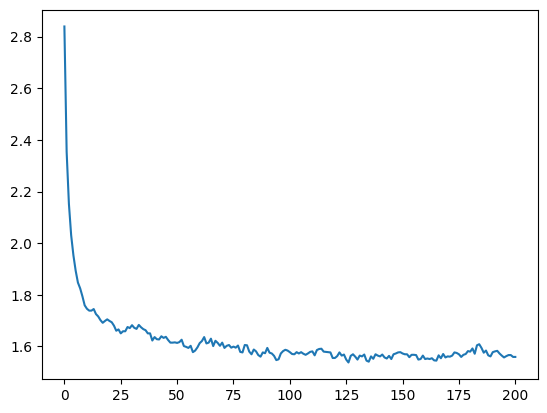

In [36]:
plt.plot(Zs.keys(),topics_per_document_avg)
print('Average number of topics per document over the iterations:')

Average number of words per topic over the iterations:


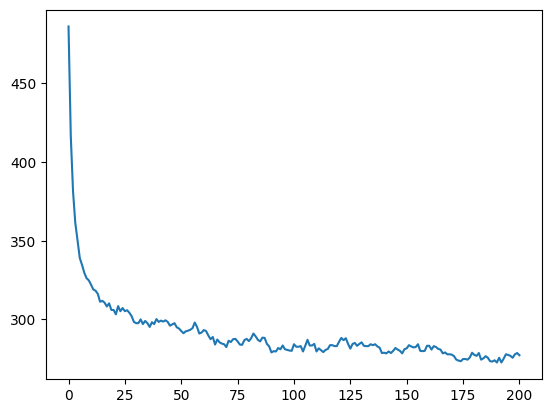

In [37]:
plt.plot(Zs.keys(),words_per_topic_avg)
print('Average number of words per topic over the iterations:')

# Inference

The result of our Gibbs Sampling process are samples from $p(Z|W)$.

Remember that we want to have an estimate $\hat{Z}$ and from there calculate $\hat{\Theta}_{\text{ML}}$ and $\hat{\Phi}_{\text{ML}}$.

Based on these we can then answer all kinds of inference queries.

### Task 5

Use the topic assignments from the sampling process $Z^{(i)}$ to estimate 

\begin{equation}
\hat{Z} = \cfrac{1}{m} \sum\limits_{i=1}^m Z^{(i)} \approx \mathbb{E}_{p(Z|W)}Z
\end{equation}

For the estimation, take every 10-th sample from the 100-th iteration onwards.

In [38]:
Z_hat = [np.zeros(Z.shape) for Z in Zs[0]]
m = 0
for i in range(100,200,10):
    Z_hat = [Z_hat[k] + Zs[i][k] for k in range(len(Z_hat))]
    m += 1
Z_hat = [z_hat/m for z_hat in Z_hat]

### Task 6

Think about what the Maximum Likelihood estimates $\hat{\Theta}_{\text{ML}}$ and $\hat{\Phi}_{\text{ML}}$ should be given $\hat{Z}$.

Use your estimate $\hat{Z}$ to calculate $\hat{\Theta}_{\text{ML}}$ and $\hat{\Phi}_{\text{ML}}$.

In [39]:
Z_hat_int = [np.rint(x) for x in Z_hat]
theta = np.empty((len(titles_indices), 5))
for doc_idx,z in enumerate(Z_hat_int):
    for topic in range(5):
        theta[doc_idx,topic] = np.count_nonzero(z==topic) # The number of times this topic occured in this document
    theta[doc_idx] = theta[doc_idx] / np.sum(theta[doc_idx])

phi = np.empty((5,len(vocab)))
z_stacked = np.hstack(Z_hat_int)
docs_stacked = np.hstack(titles_indices)
for topic in range(5):
    words_of_this_topic = docs_stacked[z_stacked==topic]
    for word,word_idx in vocab_dict.items():
        phi[topic,word_idx] = np.count_nonzero(words_of_this_topic==word_idx) # The number of times this word occured with this topic
    phi[topic] = phi[topic] / np.sum(phi[topic])

# Inference

### Task 7

For each topic, what are the top three words?

In [40]:
for topic in range(5):
    top_word_idcs = np.argsort(phi[topic])[-3:]
    print(f'For topic {topic+1}, the top three words are: {[sampler.idx2word[x] for x in top_word_idcs]}')

For topic 1, the top three words are: ['graphs', 'random', 'analysis']
For topic 2, the top three words are: ['dynamics', 'based', 'quantum']
For topic 3, the top three words are: ['network', 'neural', 'networks']
For topic 4, the top three words are: ['using', 'estimation', 'learning']
For topic 5, the top three words are: ['theory', 'state', 'model']


### Task 8

What is the topic distribution for the second title?

In [41]:
print(theta[1])

[0.         0.33333333 0.66666667 0.         0.        ]


### Task 9

Select the top 10 titles that are most typical for topic 4.

In [42]:
[titles[x] for x in np.argsort(theta[:,3])[-10:]]

['DeepFense: Online Accelerated Defense Against Adversarial Deep Learning',
 'Mutual Information, Relative Entropy and Estimation Error in Semi-martingale Channels',
 'Curvature in Hamiltonian Mechanics And The Einstein-Maxwell-Dilaton Action',
 'Finding Submodularity Hidden in Symmetric Difference',
 'Mixing of odd- and even-frequency pairings in strongly correlated electron systems under magnetic field',
 'Reassessing Graphene Absorption and Emission Spectroscopy',
 'Deep & Cross Network for Ad Click Predictions',
 'Geometrically stopped Markovian random growth processes and Pareto tails',
 'Forecasting the Impact of Stellar Activity on Transiting Exoplanet Spectra',
 'Poisoning Attacks to Graph-Based Recommender Systems']

### Task 10

Visualize the soft clustering that is induced by the topic distribution vectors for each title.

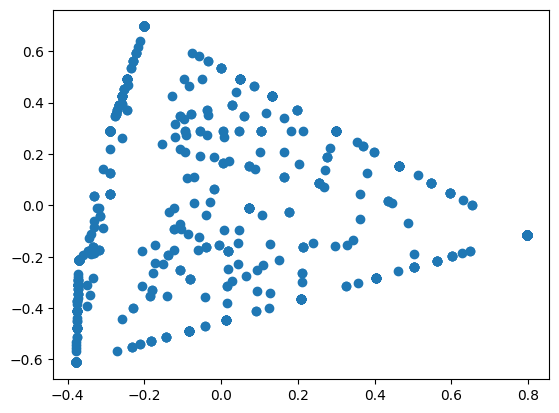

In [44]:
# We have 5 topics. Sadly, a simplex with 5 corners lives in 4D-space, so we can't simply draw it.
# I will instead draw the PCA-reduced version of our data.

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
y = pca.fit_transform(theta)
plt.scatter(y[:,0], y[:,1])
# Now, I would interpret these lines-formations as coming from the edges of the 5-corner simplex.
# Since many points lie on these lines, there are a lot of documents whose topic distribution is dominated by only 2 topics.